## Disclaimer

This workbook contains my own personal playground with data from the 2020 SARS-COV-2 Pandemic.

I am neither a statistician nor doctor and no values or results in this workbook should be taken for further publication or dissemination in any other form.

The code in this workbook makes some assumptions which have a high probability of indroducting errors in the data (f.ex. merging and matching of country names). I am awere of the issues and have not fixed them, because my main goal of this workbook is to experimnent with Python, Pandas and the data from the virus outbreak. The results are not intended to have a high degree of correctness. It is a personal project, indended for personal use.

In [ ]:
# Imports

import requests
import pandas as pd
import seaborn as sns
import numpy as np
from functools import lru_cache
import matplotlib.pyplot as plt

In [71]:
# Functions

def fetch_populations():
    """
    Fetches current data about country population
    and returns it as a mapping from countr-name
    to the population value.
    
    Some keys are duplicated to allow for country-name
    disambiguations which are returned from the API.
    """
    response = requests.get("https://restcountries.eu/rest/v2/all?fields=name;population;altSpellings")
    output = {}

    for row in response.json():
        if row["name"] in output and output[row["name"]] != row["population"]:
            raise KeyError("%s already in mapping with differing value!" % row["name"])
        output[row["name"]] = row["population"]
        for altname in row["altSpellings"]:
            if altname in output and output[altname] != row["population"]:
                raise KeyError("%s already in mapping with differing value!" % altname)
            output[altname] = row["population"]
    return output
            
def get_population(row, source_col):
    name = row[source_col]
    if name == "United Kingdom":
        name = "UK"
    return COUNTRY_POP.get(name, np.NAN)


def to_timeseries(df, var_name):
    """
    Converts the dataframe from the Johns-Hopins data-set
    which stores each date as a column, into a new data-set
    using a new row for each date.
    """
    timeseries = df.melt(
        id_vars=["Province/State", "Country/Region", "Lat", "Long"],
        var_name="Date",
        value_name=var_name
    )
    timeseries["Date"] = pd.to_datetime(timeseries["Date"], format="%m/%d/%y")
    date_indexed = timeseries.set_index("Date")
    return date_indexed.drop(["Lat", "Long"], axis="columns")

def split(df):
    """
    Splits a data-frame into smaller data-frames, one for each country, sorted by date.
    """
    fragments = {}
    for name in df["Country/Region"].unique():
        fragments[name] = df[df["Country/Region"] == name].sort_values("Date")
    return fragments 

def cases_after_first_n(df, reference_us_population):
    """
    Returns a new data-frame which only contains cases after the firt time the "confirmed"
    counter hit a certain percentage of the population. This percentage is calculated based
    on the US as reference. If this value is "500", then this will calculate how much of
    a percentage "500" represents for the population of the US and apply the same
    percentage to the country in the given data-frame.
    This new frame is indexed by the amount of days after the value was reached.
    """
    if len(df['Country/Region'].unique()) > 1:
        raise Exception("This function must me called with a data-frame of only one country")
    
    reference_rate = reference_us_population / COUNTRY_POP["US"]
    n = df.iloc[0].population * reference_rate

    matching_rows = df.index[df["confirmed"] > n].tolist()
    if len(matching_rows) == 0:
        return None
    date_of_first_n = matching_rows[0]
    trimmed = df[df.index > date_of_first_n].reset_index()
    trimmed["days_after_cutoff"] = (trimmed["Date"] - date_of_first_n).astype('timedelta64[D]')
    return trimmed.set_index("days_after_cutoff")
    
def shift(df, field):
    """
    Create two new fields derived from *field_name*. These new
    fields are added with prefixes in the column names:
    
    * ``previous_<field>``: The same values as in ``<field>``,
      but offset by one row.
    * ``delta_<field>``: The difference between ``<field>``
      and ``previous_<field>``

    Example:
    
    >>> df = pd.DataFrame([
    ...    [1, 2, 3],
    ...    [6, 6, 6],
    ...    [7, 7, 7]],
    ...    columns=['a', 'b', 'c'])
    >>> df
       a  b  c
    0  1  2  3
    1  6  6  6
    2  7  7  7
    >>> shift(df, 'b')
    >>> df
       a  b  c  previous_b  delta_b
    0  1  2  3         NaN      NaN
    1  6  6  6         2.0      4.0
    2  7  7  7         6.0      1.0
    """
    df["previous_" + field] = df[field].shift()
    df["delta_" + field] = df[field] - df["previous_" + field]

def shift_all(df):
    shift(df, "confirmed_per_capita")
    shift(df, "recovered_per_capita")
    shift(df, "deaths_per_capita")
    shift(df, "confirmed")
    shift(df, "recovered")
    shift(df, "deaths")

def plot(df, field):
    f, ax = plt.subplots(figsize=(15,10))
    sns.set_palette("colorblind")
    sns.lineplot(
        x=df.index,
        y=field,
        data=df,
        hue="Country/Region")
    
def smooth(df, field):
    """
    Run a rolling-window average over ``field`` and create
    it as a new field in ``df`` with the prefix ``smooth_``
    """
    df["smooth_" + field] = df[field].rolling(3, center=True).mean()

    
def prepare_for_plot(df):
    countrydata = split(df)
    trimmed_countrydata = {}
    for country, frame in countrydata.items():
        trimmed = cases_after_first_n(frame, 100)
        if trimmed is None:
            continue
        shift_all(trimmed)
        smooth(trimmed, "delta_confirmed_per_capita")
        trimmed_countrydata[country] = trimmed
    output = pd.concat(trimmed_countrydata.values()).reset_index().set_index(["days_after_cutoff"])
    return output

In [72]:
COUNTRY_POP = fetch_populations()

# Read the initial data-frames from the Johns Hopkins data set
BASE_URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series"
confirmed = pd.read_csv(BASE_URL + "/time_series_covid19_confirmed_global.csv")
deaths = pd.read_csv(BASE_URL + "/time_series_covid19_deaths_global.csv")
recovered = pd.read_csv(BASE_URL + "/time_series_covid19_recovered_global.csv")

# Convert to row-based time-series
confirmed_ts = to_timeseries(confirmed, "confirmed")
deaths_ts = to_timeseries(deaths, "deaths")
recovered_ts = to_timeseries(recovered, "recovered")

with_deaths = pd.merge(confirmed_ts, deaths_ts, on=["Date", "Province/State", "Country/Region"])

# Merge "recovered" into the data-set. This new data-frame will contain all values
# (confirmed, recovered and deaths) for each country
with_recovered = pd.merge(with_deaths, recovered_ts, on=["Date", "Province/State", "Country/Region"])

# Add a new column containing the population of the country for that row
with_recovered["population"] = with_recovered.apply(lambda row: get_population(row, "Country/Region"), axis=1)

# Remove "Province/State" and sum the values, giving us only one entry per country
with_recovered.drop("Province/State", axis="columns")
with_recovered = with_recovered.groupby(by=["Date", "Country/Region", "population"]).sum()
with_recovered = with_recovered.reset_index()
with_recovered = with_recovered.set_index("Date")

# Calculate the values "per-capita" (per 1'000 inhabitants) for each country
with_recovered['confirmed_per_capita'] = with_recovered['confirmed'] / with_recovered['population'] * 1e3
with_recovered['deaths_per_capita'] = with_recovered['deaths'] / with_recovered['population'] * 1e3
with_recovered['recovered_per_capita'] = with_recovered['recovered'] / with_recovered['population'] * 1e3

# Split into one data-frame per country so we can manipulate each one separately
recombined = prepare_for_plot(with_recovered)

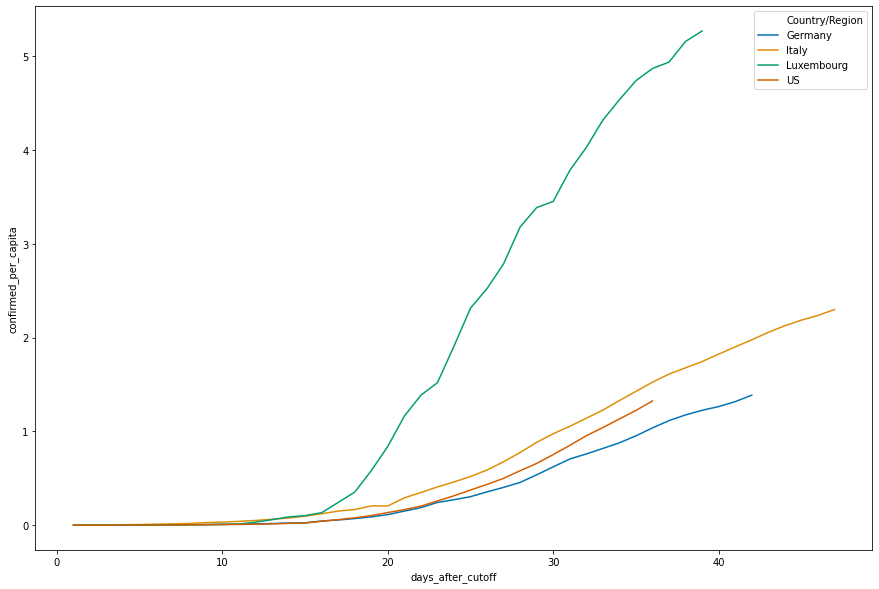

In [73]:
# plot stuff

for_plot = recombined[
    (recombined['Country/Region'] == "Luxembourg") |
    (recombined['Country/Region'] == "US") |
    (recombined['Country/Region'] == "Germany") |
    (recombined['Country/Region'] == "Italy")
].sort_values("days_after_cutoff")
plot(for_plot, "confirmed_per_capita")

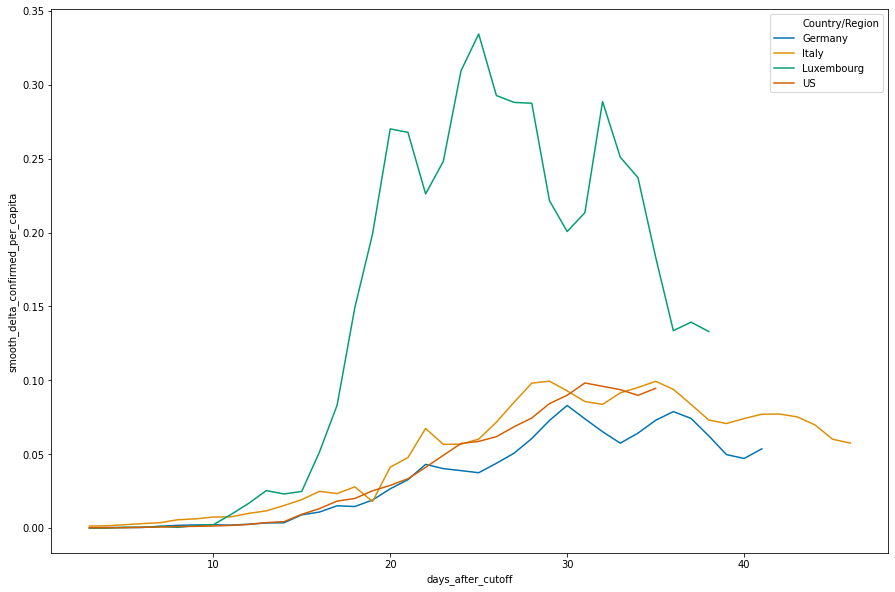

In [68]:
plot(for_plot, "smooth_delta_confirmed_per_capita")

# Playground

Everything below is "work-in-progress" playground

In [69]:
lux = recombined[recombined["Country/Region"] == "Luxembourg"].copy()
lux["i"] = lux["confirmed"] / lux["population"]
lux["s"] = (lux["population"] - lux["confirmed"]) / lux["population"]
lux["r"] = (lux["recovered"] + lux["deaths"]) / lux["population"]
transmission_rate = 1.0
lux["rate_of_infection"] = transmission_rate * lux["s"] * lux["i"]
lux

,Date,Country/Region,population,confirmed,deaths,recovered,confirmed_per_capita,deaths_per_capita,recovered_per_capita,previous_confirmed_per_capita,...,delta_confirmed,previous_recovered,delta_recovered,previous_deaths,delta_deaths,smooth_delta_confirmed_per_capita,i,s,r,rate_of_infection
days_after_cutoff,,,,,,,,,,,,,,,,,,,,,
1.0,2020-03-01,Luxembourg,576200.0,1,0,0,0.001736,0.000000,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,0.999998,0.000000,0.000002
2.0,2020-03-02,Luxembourg,576200.0,1,0,0,0.001736,0.000000,0.000000,0.001736,...,0.0,0.0,0.0,0.0,0.0,NaN,0.000002,0.999998,0.000000,0.000002
3.0,2020-03-03,Luxembourg,576200.0,1,0,0,0.001736,0.000000,0.000000,0.001736,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000002,0.999998,0.000000,0.000002
4.0,2020-03-04,Luxembourg,576200.0,1,0,0,0.001736,0.000000,0.000000,0.001736,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000002,0.999998,0.000000,0.000002
5.0,2020-03-05,Luxembourg,576200.0,1,0,0,0.001736,0.000000,0.000000,0.001736,...,0.0,0.0,0.0,0.0,0.0,0.000579,0.000002,0.999998,0.000000,0.000002
6.0,2020-03-06,Luxembourg,576200.0,2,0,0,0.003471,0.000000,0.000000,0.001736,...,1.0,0.0,0.0,0.0,0.0,0.000579,0.000003,0.999997,0.000000,0.000003
7.0,2020-03-07,Luxembourg,576200.0,2,0,0,0.003471,0.000000,0.000000,0.003471,...,0.0,0.0,0.0,0.0,0.0,0.001157,0.000003,0.999997,0.000000,0.000003
8.0,2020-03-08,Luxembourg,576200.0,3,0,0,0.005207,0.000000,0.000000,0.003471,...,1.0,0.0,0.0,0.0,0.0,0.000579,0.000005,0.999995,0.000000,0.000005
9.0,2020-03-09,Luxembourg,576200.0,3,0,0,0.005207,0.000000,0.000000,0.005207,...,0.0,0.0,0.0,0.0,0.0,0.001736,0.000005,0.999995,0.000000,0.000005


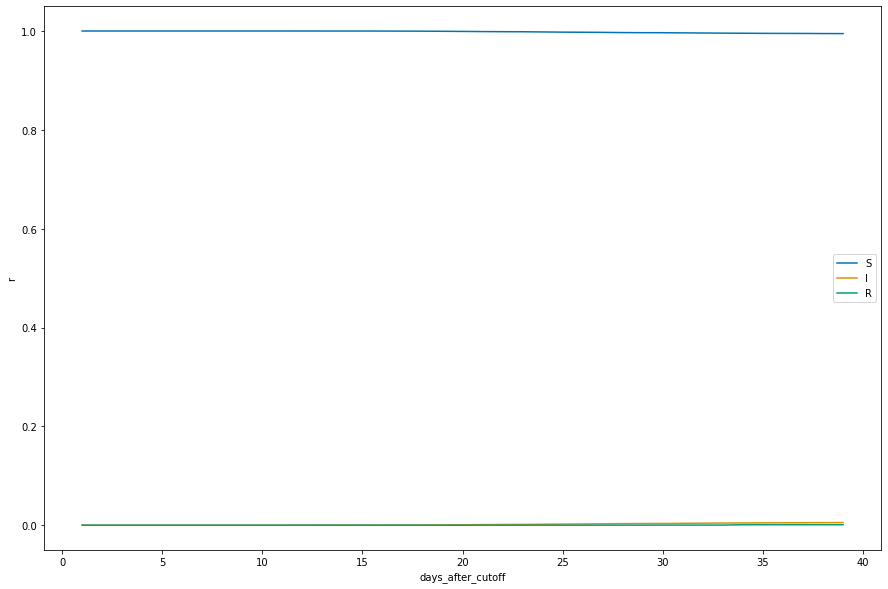

In [70]:
f, ax = plt.subplots(figsize=(15,10))
sns.set_palette("colorblind")
sns.lineplot(x=lux.index, y=lux["s"], data=lux, label="S")
sns.lineplot(x=lux.index, y=lux["i"], data=lux, label="I")
sns.lineplot(x=lux.index, y=lux["r"], data=lux, label="R")
plt.legend()